# CS282r - Fall 2017 
## Improve Sepsis Treatment using Mixture of Experts
## Gating via Reinforcement Learning

Jerry, Yi, David

In [1]:
%matplotlib inline
import pickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
MIN_INT_VALUE = -sys.maxsize - 1

import seaborn as sns; sns.set()
from collections import Counter

import restrictactions as ra
n_states = 750
n_actions = 25


## Load Data and Experts

In [2]:
# Baseline dataset
train_set = pd.read_csv('../../data/train_scaled_dw.csv') #('../../data/train_scaled_encoded.csv') #
test_set = pd.read_csv('../../data/test_scaled_dw.csv')
print ("Initial train set shape:",train_set.shape)
print ("Initial test set shape:",test_set.shape)

Initial train set shape: (150741, 61)
Initial test set shape: (50859, 61)


In [3]:
# Features used to drive expert selection
# => Obsolete
# train_input = pd.read_csv('../../data/train_input_features.csv')
# test_input = pd.read_csv('../../data/test_input_features.csv')
# test_input.columns

In [4]:
# Calculated state for each row in baseline
train_state_list = pkl.load(open('../../data/classify_state/train_states.pkl', 'rb'), encoding='latin1')
train_set['state'] = train_state_list
test_state_list = pkl.load(open('../../data/classify_state/test_states.pkl', 'rb'), encoding='latin1')
test_set['state'] = test_state_list

In [5]:
print ("Initial train set shape:",train_set.shape)
print ("Initial test set shape:",test_set.shape)

Initial train set shape: (150741, 62)
Initial test set shape: (50859, 62)


In [6]:
# add in kernel policy
train_kernel_policy = pkl.load(open('../../data/train_kernel_policy_transformed.pkl', 'rb'), encoding='latin1')
train_set['krn_action'] = train_kernel_policy[:,3].astype(int)
test_kernel_policy = pkl.load(open('../../data/test_kernel_policy_transformed.pkl', 'rb'), encoding='latin1')
test_set['krn_action'] = test_kernel_policy[:,3].astype(int)

In [7]:
# add in DQN policy
train_dqn_policy = pd.DataFrame({'dqn_action':
                           pkl.load(open('../../data/dqn/train_agent_actions_2m.pkl', 'rb'), encoding='latin1')})
test_dqn_policy = pd.DataFrame({'dqn_action':
                           pkl.load(open('../../data/dqn/test_agent_actions_2m.pkl', 'rb'), encoding='latin1')})

train_set = pd.concat([train_set,train_dqn_policy],axis=1)
test_set = pd.concat([test_set,test_dqn_policy],axis=1)


In [8]:
# Remove rows for invalid patients
train_set.drop(train_set[train_set['icustayid'].
                         isin([76921.0,77243.0,90270.0,91090.0,98366.0])].index, inplace=True)
train_set.drop(train_set[train_set['icustayid'].isnull()].index, inplace=True)
test_set.drop(test_set[test_set['icustayid'].
                       isin([37166.0,67895.0,68546.0,85154.0])].index,inplace=True)
test_set.drop(test_set[test_set['icustayid'].isnull()].index, inplace=True)
print ("New train set shape:",train_set.shape)
print ("New test set shape:",test_set.shape)

New train set shape: (150673, 64)
New test set shape: (50798, 64)


In [9]:
# Map actions to a single value in [0..24]
action_map = {}
count = 0
for iv in range(5):
    for vaso in range(5):
        action_map[(vaso,iv)] = count
        count += 1
        
def label_action(row):
    return action_map[(row['vaso_input'],int(row['iv_input']))]

train_set['phy_action'] = train_set.apply(lambda row: label_action(row),axis=1)
test_set['phy_action'] = test_set.apply(lambda row: label_action(row),axis=1)

### Simple Exploratory Data Analysis

In [11]:
# Get baseline mortality
#mortality_90d
episodes = test_set.groupby('icustayid')
n_died = 0
n_died2 = 0
n_episodes = 0
for name, transitions in episodes:
    n_episodes += 1
    rewards = transitions['reward'].tolist()
    n_died2 += transitions['mortality_90d'].tolist()[0]
    if rewards[-1] < 0:
        n_died += 1

print ("Testing Set Baseline mortality: {0:.1%}".format(n_died / n_episodes))
print ("Testing Set 90 day mortality: {0:.1%}".format(n_died2/n_episodes))

episodes = train_set.groupby('icustayid')
n_died = 0
n_died2
n_episodes = 0
for name, transitions in episodes:
    n_episodes += 1
    rewards = transitions['reward'].tolist()
    n_died2 += transitions['mortality_90d'].tolist()[0]

    if rewards[-1] < 0:
        n_died += 1

print ("Training Set Baseline mortality: {0:.1%}".format(n_died / n_episodes))
print ("Training Set 90 day mortality: {0:.1%}".format(n_died2/n_episodes))



Testing Set Baseline mortality: 12.3%
Testing Set 90 day mortality: 23.3%
Training Set Baseline mortality: 12.2%
Training Set 90 day mortality: 30.0%


In [12]:
train_set.head()

,bloc,icustayid,gender,age,elixhauser,re_admission,SOFA,SIRS,Weight_kg,GCS,...,rrt,died_in_hosp,mortality_90d,reward,vaso_input,iv_input,state,krn_action,dqn_action,phy_action
0,0.000000,12.0,1.0,0.203388,0.000000,0.0,0.304348,0.25,0.183842,1.000000,...,0.0,0.0,0.0,15.0,0.0,0.0,126,0,13,0
1,0.222560,12.0,1.0,0.203388,0.000000,0.0,0.130435,0.50,0.183842,1.000000,...,0.0,0.0,0.0,15.0,0.0,0.0,233,0,15,0
2,0.356608,12.0,1.0,0.203388,0.000000,0.0,0.086957,0.50,0.183842,1.000000,...,0.0,0.0,0.0,15.0,0.0,0.0,233,0,15,0
3,0.452837,12.0,1.0,0.203388,0.000000,0.0,0.217391,0.50,0.183842,1.000000,...,0.0,0.0,0.0,15.0,0.0,0.0,264,0,15,0
4,0.000000,14.0,0.0,0.909010,0.142857,0.0,0.217391,0.50,0.204211,0.047619,...,0.0,0.0,1.0,15.0,0.0,4.0,492,0,9,20


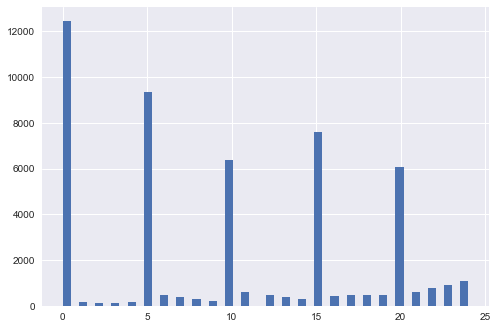

In [13]:
plt.hist(test_set['phy_action'],50)
pass

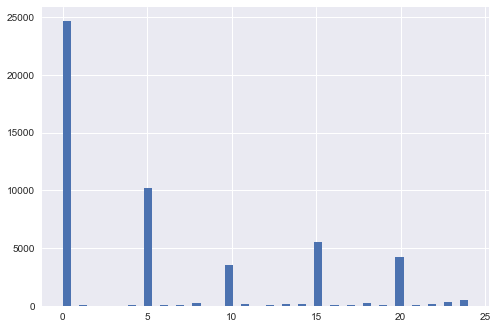

In [14]:
plt.hist(test_set['krn_action'],50)
pass

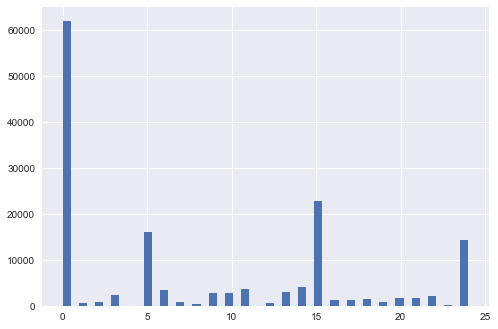

In [15]:
plt.hist(train_dqn_policy['dqn_action'],50)
pass

(array([ 5857.,  5684.,  5314.,  4446.,  6000.,  4804.,  5428.,  4128.,
         4651.,  4486.]),
 array([   0. ,   74.9,  149.8,  224.7,  299.6,  374.5,  449.4,  524.3,
         599.2,  674.1,  749. ]),
 <a list of 10 Patch objects>)

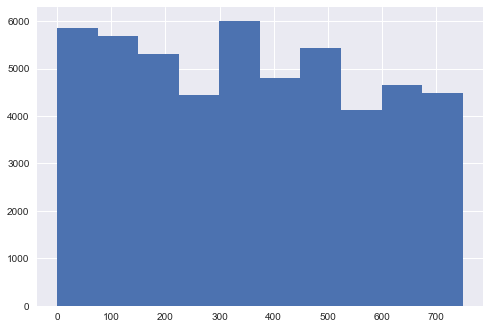

In [16]:
plt.hist(test_set['state'])

(array([ 17593.,  17913.,  16850.,  13994.,  16192.,  14906.,  15780.,
         11878.,  12989.,  12578.]),
 array([   0. ,   74.9,  149.8,  224.7,  299.6,  374.5,  449.4,  524.3,
         599.2,  674.1,  749. ]),
 <a list of 10 Patch objects>)

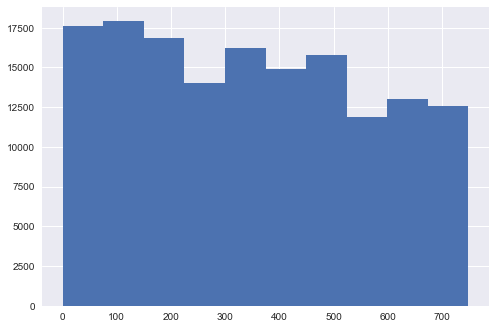

In [17]:
plt.hist(train_set['state'])

### Rewards and Terminal states

In [18]:
state_rewards = np.zeros((n_states))
state_reward_count = np.ones((n_states))
terminal_state = []

for name, transitions in episodes:
    states = transitions['state'].tolist()
    rewards = transitions['reward'].tolist()
    terminal_state.append(states[-1])
    state_rewards[states[-1]] += rewards[-1]
    state_reward_count[states[-1]] += 1

state_rewards = state_rewards / state_reward_count

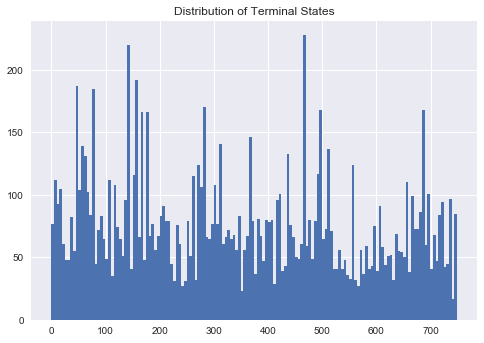

In [19]:
plt.hist(terminal_state,150)
plt.title("Distribution of Terminal States")
pass

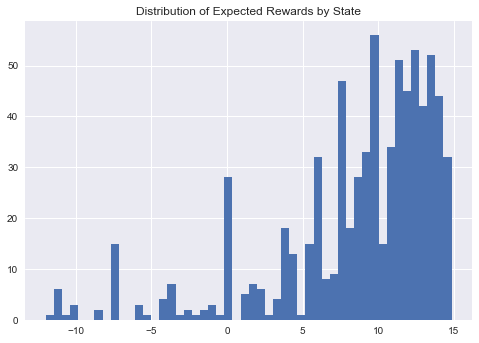

In [20]:
plt.hist(state_rewards,50)
plt.title("Distribution of Expected Rewards by State")
pass

Conclusion: there isn't a particular small set of states that are considered "terminal." However, some
terminal states have significantly more rewards than others. Choose the path that leads to the highest rewards.

In [21]:
norm_state_rewards = (state_rewards - np.mean(state_rewards))/np.std(state_rewards)

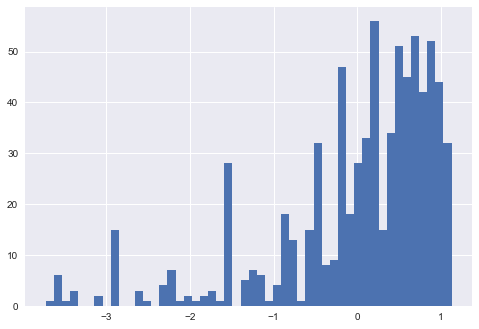

In [25]:
plt.hist(norm_state_rewards,50)
pass

In [23]:
def sigmoid_array(x):                                        
    return 1 / (1 + np.exp(-x))

s_state_values = sigmoid_array(norm_state_rewards)

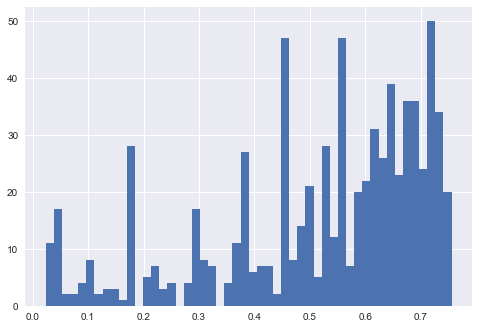

In [26]:
plt.hist(s_state_values,50)
pass

### Populate Restricted Actions for Each Expert

In [27]:
#import importlib
#importlib.reload(ra)

In [28]:
# One for each expert
phy_ra = ra.RestrictActions(n_states,n_actions)
phy_ra.load_sas_as_episodes(episodes,'phy_action')

krn_ra = ra.RestrictActions(n_states,n_actions)
krn_ra.load_sas_as_episodes(episodes,'krn_action')

dqn_ra = ra.RestrictActions(n_states,n_actions)
dqn_ra.load_sas_as_episodes(episodes,'dqn_action')

experts = [phy_ra,krn_ra,dqn_ra]
expert_names = {phy_ra:'Physician',dqn_ra:'DQN',krn_ra:'Kernel'}

## Mixture of Experts Policy Selection Based on RL

Method:

* If there is physician consensus for a given action at a given state, simply choose it.
* If there is no consensus, walk the three action choices and pick the action that leads to
the state with the highest reward.

In [29]:
max_depth = 20
min_freq = 10
max_episodes = 200 # saving processing time to not report on all test episodes
stats_same_actions = np.zeros((len(experts),len(experts)))
stats_action_chosen = Counter()


In [30]:
def perform_phy_action(state,action):
    reward = state_rewards[state]
    state = int(np.max(phy_ra.sas_count[state,action]))
    return state, reward

In [31]:
def calc_different_actions(actions,experts):
    global stats_same_actions
    for expert_action in actions:
        for expert in experts:
            if actions[expert_action] == actions[expert]:
                stats_same_actions[experts.index(expert_action),experts.index(expert)] += 1


In [32]:
def perform_best_action(state,experts):
    global stats_action_chosen
    max_reward = MIN_INT_VALUE
    best_action = 0
    new_state = -1
    rewards = {expert: 0 for expert in experts}
    actions = {expert: -1 for expert in experts}
    
    for expert in experts:
        for a in expert.get_actions(state,min_freq=min_freq):
            for s in range(len(expert.sas_count[state][a])):
                if expert.sas_count[state][a][s] < min_freq:
                    continue
                if state_rewards[s] > rewards[expert]:
                    rewards[expert] = state_rewards[s]
                    actions[expert] = a
                    new_state = s
    
    max_reward = rewards[max(rewards,key=rewards.get)]
    best_action = actions[max(rewards,key=rewards.get)]
    calc_different_actions(actions,experts)
    stats_action_chosen[expert_names[max(rewards,key=rewards.get)]] += 1
    
    if new_state >= 0:
        return best_action, new_state, max_reward
    else:
        return None, None, None

In [34]:
# Three experts

test_episodes = test_set.groupby('icustayid')

print ("|Physician Consensus | Mortality | Phy Consensus Occurred |")
print ("|:---|---|---:|")
action_count25 = np.zeros((n_actions))
for physician_consensus in [0.1,0.2,0.25,0.3]:#,0.4,0.5,0.6,0.7]: 
    global dqn_action_counts, phy_action_counts
    n_died = 0
    n_episodes = 0
    actions_taken = 1 # avoid divide by zero
    stats_same_actions = np.zeros((len(experts),len(experts)))
    stats_action_chosen.clear()

    stats_phy_chosen = 0
    stats_dqn_chosen = 0
    stats_phy_consensus = 0
    stats_no_action = 0
    stats_different_actions = 0
    action_counts = np.zeros((n_actions))
    dqn_action_counts = np.zeros((n_actions))
    phy_action_counts = np.zeros((n_actions))

    for name, transitions in test_episodes:
        n_episodes += 1
        if n_episodes > max_episodes:
            break
        state = transitions['state'].tolist()[0]
        depth = 0 
        action_list = []
        state_list = []
        episode_reward = 0
        while True:
            if depth > max_depth:
                break
            depth += 1
            actions_taken += 1
            state = int(state)
            action = phy_ra.get_consensus(state,physician_consensus)
            if action is None:
                action, state, reward = perform_best_action(state,experts)
            else:
                state, reward = perform_phy_action(state,action)
                stats_phy_consensus += 1
            if reward is None:
                break
            elif reward < 0:
                n_died += 1
                break
            else:
                action_counts[action] +=1 
                if physician_consensus == 0.25:
                    action_count25[action] += 1
                episode_reward += reward
    print ("| {0:.0%} ".format(physician_consensus), end="")
    print ("| {0:.1%} ".format(n_died / n_episodes), end="")
    print ("| {0:.1%} |".format(stats_phy_consensus / actions_taken))
    sum(stats_action_chosen.values())
    print (dict(stats_action_chosen))
    print (stats_same_actions)


|Physician Consensus | Mortality | Phy Consensus Occurred |
|:---|---|---:|
| 10% | 13.4% | 100.0% |
{}
[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
| 20% | 10.0% | 23.1% |
{'Physician': 2547, 'Kernel': 338}
[[ 2885.   128.   102.]
 [  128.  2885.  1415.]
 [  102.  1415.  2885.]]
| 25% | 3.5% | 11.0% |
{'Physician': 2859, 'Kernel': 563, 'DQN': 3}
[[ 3425.   576.   275.]
 [  576.  3425.  1123.]
 [  275.  1123.  3425.]]
| 30% | 2.5% | 5.9% |
{'Physician': 2782, 'Kernel': 788, 'DQN': 5}
[[ 3575.  1282.   539.]
 [ 1282.  3575.  1319.]
 [  539.  1319.  3575.]]


In [42]:
1415 / (2885 + 128 + 102)

0.45425361155698235

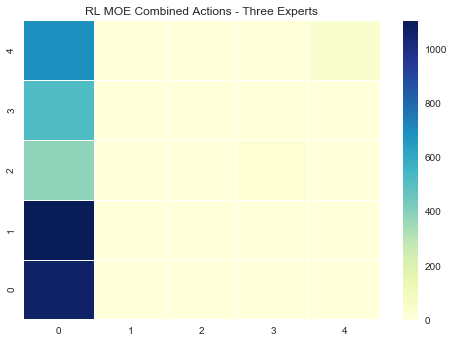

In [36]:
ax = sns.heatmap(action_count25.reshape(5,5), linewidths=.01, cmap="YlGnBu")
ax.invert_yaxis()
ax.set_title('RL MOE Combined Actions - Three Experts')

In [37]:
# Two Experts

experts = [krn_ra,dqn_ra]
expert_names = {dqn_ra:'DQN',krn_ra:'Kernel'}
test_episodes = test_set.groupby('icustayid')

print ("|Physician Consensus | Mortality | Phy Consensus Occurred |")
print ("|:---|---|---:|")
action_count25 = np.zeros((n_actions))
for physician_consensus in [0.1,0.2,0.25,0.3]:#,0.4,0.5,0.6,0.7]: 
    global dqn_action_counts, phy_action_counts
    n_died = 0
    n_episodes = 0
    actions_taken = 1 # avoid divide by zero
    stats_same_actions = np.zeros((len(experts),len(experts)))
    stats_action_chosen.clear()

    stats_phy_chosen = 0
    stats_dqn_chosen = 0
    stats_phy_consensus = 0
    stats_no_action = 0
    stats_different_actions = 0
    action_counts = np.zeros((n_actions))
    dqn_action_counts = np.zeros((n_actions))
    phy_action_counts = np.zeros((n_actions))

    for name, transitions in test_episodes:
        n_episodes += 1
        if n_episodes > max_episodes:
            break
        state = transitions['state'].tolist()[0]
        depth = 0 
        action_list = []
        state_list = []
        episode_reward = 0
        while True:
            if depth > max_depth:
                break
            depth += 1
            actions_taken += 1
            state = int(state)
            action = phy_ra.get_consensus(state,physician_consensus)
            if action is None:
                action, state, reward = perform_best_action(state,experts)
            else:
                state, reward = perform_phy_action(state,action)
                stats_phy_consensus += 1
            if reward is None:
                break
            elif reward < 0:
                n_died += 1
                break
            else:
                action_counts[action] +=1 
                if physician_consensus == 0.25:
                    action_count25[action] += 1
                episode_reward += reward
    print ("| {0:.0%} ".format(physician_consensus), end="")
    print ("| {0:.1%} ".format(n_died / n_episodes), end="")
    print ("| {0:.1%} |".format(stats_phy_consensus / actions_taken))
    sum(stats_action_chosen.values())
    print (dict(stats_action_chosen))
    print (stats_same_actions)


|Physician Consensus | Mortality | Phy Consensus Occurred |
|:---|---|---:|
| 10% | 13.4% | 100.0% |
{}
[[ 0.  0.]
 [ 0.  0.]]
| 20% | 10.0% | 23.1% |
{'Kernel': 2885}
[[ 2885.  1415.]
 [ 1415.  2885.]]
| 25% | 3.5% | 11.0% |
{'Kernel': 3422, 'DQN': 3}
[[ 3425.  1123.]
 [ 1123.  3425.]]
| 30% | 2.5% | 5.9% |
{'Kernel': 3568, 'DQN': 7}
[[ 3575.  1319.]
 [ 1319.  3575.]]


In [43]:
1415 / (2885 + 1415)

0.32906976744186045

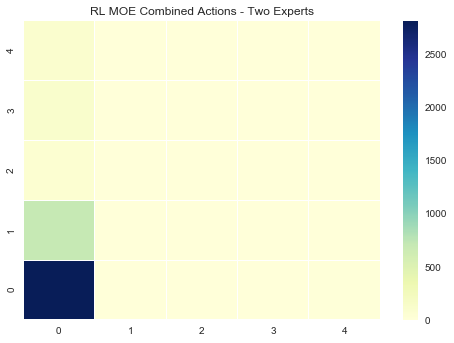

In [38]:
ax = sns.heatmap(action_count25.reshape(5,5), linewidths=.01, cmap="YlGnBu")
ax.invert_yaxis()
ax.set_title('RL MOE Combined Actions - Two Experts')

# WARNING - Here Be Dragons

## Experimental Area: proceed with caution. 

The author is not responsible for any damage, temporary or permanent.

### Is this a valid proxy for rewards?

Let's examine the predicted mortality vs the actual mortality to see if this calculated reward is a valid proxy. We'll see the physician consensus to the be closest value to the actual mortality and check error rates. 

In [25]:
print ("|Physician Consensus | Mortality | Phy Consensus Occurred |")
print ("|:---|---|---:|")
action_count25 = np.zeros((n_actions))
physician_consensus = 0.20 # on the test, where the predicted mortality is closest to the actual mortality
                            # 10.2% vs 12.2%
n_died = 0
n_episodes = 0
actions_taken = 1 # avoid divide by zero
stats_same_actions = np.zeros((len(experts),len(experts)))
stats_action_chosen.clear()

stats_phy_chosen = 0
stats_dqn_chosen = 0
stats_phy_consensus = 0
stats_no_action = 0
stats_different_actions = 0
action_counts = np.zeros((n_actions))
dqn_action_counts = np.zeros((n_actions))
phy_action_counts = np.zeros((n_actions))
TP = TN = FP = FN = 0
none_reward = 0
pred_prob = []
y_pred = []
y_actual = []
# iterate through all training episodes
for name, transitions in episodes:
    n_episodes += 1
    if n_episodes > max_episodes:
        break
    state = transitions['state'].tolist()[0]
    actual_died = transitions['reward'].tolist()[-1] < 0
    depth = 0 
    action_list = []
    state_list = []
    episode_reward = 0
    while True:
        if depth > max_depth:
            break
        depth += 1
        actions_taken += 1
        state = int(state)
        action = phy_ra.get_consensus(state,physician_consensus)
        if action is None:
            action, state, reward = perform_best_action(state,experts)
        else:
            state, reward = perform_phy_action(state,action)
            stats_phy_consensus += 1
        if reward is None:
            break
        elif reward < 0:
            n_died += 1
            break
        else:
            action_counts[action] +=1 
            if physician_consensus == 0.25:
                action_count25[action] += 1
            episode_reward += reward
    # negative = patient died
    # positive = patient lived
    #print (state,s_state_values[state],actual_died)
    if reward is not None:
        pred_prob.append(s_state_values[state])
        if actual_died:
            y_actual.append(0)
        else:
            y_actual.append(1)

        if reward < 0:
            y_pred.append(0)
        else:
            y_pred.append(1)
        if reward < 0 and actual_died:
            TN += 1
        elif reward >= 0 and actual_died:
            FP += 1
        elif reward < 0 and not actual_died:
            FN += 1
        else:
            TP += 1
    else:
        none_reward += 1

# print ("| {0:.0%} ".format(physician_consensus), end="")
# print ("| {0:.1%} ".format(n_died / n_episodes), end="")
# print ("| {0:.1%} |".format(stats_phy_consensus / actions_taken))
# sum(stats_action_chosen.values())
# print (dict(stats_action_chosen))
# print (stats_same_actions)

print ("TN:",TN,"FP:",FP,"FN:",FN,"TP:",TP)

|Physician Consensus | Mortality | Phy Consensus Occurred |
|:---|---|---:|
TN: 5 FP: 17 FN: 15 TP: 157


In [29]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_actual, pred_prob)
roc_auc  = metrics.auc(fpr, tpr)
metrics.auc(fpr,tpr)

0.50819238900634256

In [30]:
print (tpr)

[ 0.          0.02325581  0.02906977  0.03488372  0.05813953  0.0755814
  0.11627907  0.12209302  0.14534884  0.5         0.52325581  0.54069767
  0.5872093   0.59302326  0.59883721  0.88372093  0.94767442  1.        ]


In [31]:
print ("TN:",TN,"FP:",FP,"FN:",FN,"TP:",TP)


TN: 5 FP: 17 FN: 15 TP: 157


In [105]:
tpr

array([ 0.        ,  0.0326087 ,  0.04347826,  0.06521739,  0.07608696,
        0.10869565,  0.13043478,  0.51086957,  0.5326087 ,  0.55434783,
        0.63043478,  0.63043478,  0.64130435,  0.89130435,  0.9673913 ,  1.        ])

/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


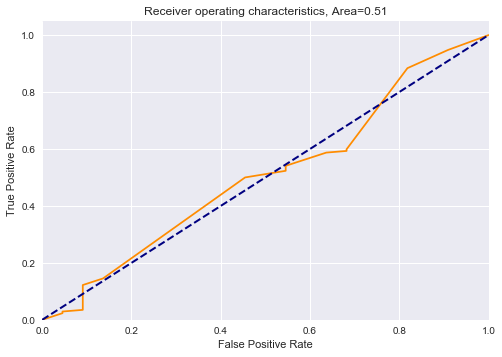

In [32]:
lw =2
plt.plot(fpr, tpr, color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristics, Area={0:0.2f}'.format(roc_auc))
plt.legend(loc="lower right")
plt.show()

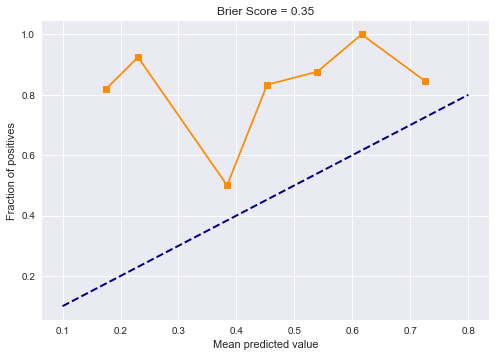

In [33]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_actual, pred_prob, n_bins=10)

plt.plot(mean_predicted_value, fraction_of_positives, "s-",color='darkorange')
plt.plot([0.1, 0.8], [0.1, 0.8], color='navy', lw=lw, linestyle='--')

plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of positives")
plt.title('Brier Score = {0:0.2f}'.format(metrics.brier_score_loss(y_actual,pred_prob)))


### Next Steps

Mortality on:
* Is RL MOE accurate?
    * Brier score
    * Precision recall score
    * AUROC curve

See method in [https://arxiv.org/abs/1711.06402](https://arxiv.org/abs/1711.06402)


Time permitting: 
* hunt down bug in discretize physician actions